In [386]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim

In [387]:

class NBADataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = self._load_data()

    def _load_data(self):
        df = pd.read_csv(self.file_path, index_col=0)
        return df

    def _add_target(self, group):
        group = pd.concat([group, group["won"].shift(-1).rename("target")], axis=1)
        return group

    def _scale_data(self, df, selected_columns):
        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])
        return df

    def _calculate_rolling_averages(self, df, selected_columns):
        rolling = df[list(selected_columns) + ["won", "team", "season"]]
        
        def find_team_averages(team):
            team[selected_columns] = team[selected_columns].rolling(10).mean()
            return team

        rolling = rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

        return rolling

    def _add_future_game_data(self, df):
        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col

        df["home_next"] = self._add_col(df, "home")
        df["team_opp_next"] = self._add_col(df, "team_opp")
        df["date_next"] = self._add_col(df, "date")

        return df

    def _add_col(self, df, col_name):
        return df.groupby("team", group_keys=False).apply(lambda x: self._shift_col(x, col_name))

    def _shift_col(self, team, col_name):
        next_col = team[col_name].shift(-1)
        return next_col

    def prepare_dataset(self):
        # Sort by date and drop irrelevant columns
        self.df = self.df.sort_values("date")
        self.df = self.df.reset_index(drop=True)
        del self.df["mp.1"]
        del self.df["mp_opp.1"]
        del self.df["index_opp"]

        #Add a target column (Whether or not team won next game)
        self.df = self.df.groupby("team", group_keys=False).apply(self._add_target)
        self.df.loc[pd.isnull(self.df["target"]), "target"] = 2
        self.df["target"] = self.df["target"].astype(int, errors="ignore")
        
        #Create copy dataframe without null values
        nulls = pd.isnull(self.df).sum()
        nulls = nulls[nulls > 0]
        valid_columns = self.df.columns[~self.df.columns.isin(nulls.index)]
        self.df = self.df[valid_columns].copy()
        
        #Convert boolean column to binary
        self.df['won'] = self.df['won'].astype(int)
        
        #Scale stat columns
        removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
        selected_columns = self.df.columns[~self.df.columns.isin(removed_columns)]
        self.df = self._scale_data(self.df, selected_columns)
        rolling = self._calculate_rolling_averages(self.df, selected_columns)
        
        rolling_cols = [f"{col}_10" for col in rolling.columns]
        rolling.columns = rolling_cols
        
        #Concatenate new columns back into dataframe, dropping null and resetting index
        self.df = pd.concat([self.df, rolling], axis=1)
        self.df = self.df.dropna()
        self.df = self.df.reset_index(drop=True)

        #Add future game data to columns
        self.df = self._add_future_game_data(self.df)
        
        self.df = self.df.merge(self.df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])
        
        # Filter columns with _x or _y suffix, excluding opp_10_x and opp_10_y, and keep 'home_next'
        suffix_columns = [col for col in self.df.columns if col.endswith(('_x', '_y')) and 'opp_10' not in col]
        additional_columns = ['home_next','date_next', 'season', 'target']
        selected_columns = suffix_columns + additional_columns
        self.df = self.df[selected_columns]

        return self.df
    
    def _extract_features(self, df):
        
        # # Extract features for team_x and team_opp_next_x
        # team_x_cols = [col for col in df.columns if '_10_x' in col and 'opp' not in col]
        # team_opp_next_x_cols = [col for col in df.columns if 'opp_10_x' in col]

        # # Concatenate features and rolling averages, including home_next
        # features_columns = team_x_cols + team_opp_next_x_cols + ["home_next"]
        
        removed_columns = list(self.df.columns[self.df.dtypes == "object"])
        selected_columns = self.df.columns[~self.df.columns.isin(removed_columns)]
        
        # Exclude columns with specific words
        excluded_words = ["season", "date", "won", "target", "team", "team_opp"]
        features_columns = [col for col in selected_columns if not any(word in col for word in excluded_words)]
        # features_columns = [col for col in features_columns if not any(word in col for word in excluded_words)]
        
        features_df = df[features_columns].copy()

        return features_df
    
    def load_training_data(self):
        season_df = self.df[["season", "target"]].copy()

        # Extract features and target using the _extract_features method
        features_df = self._extract_features(self.df)

        # Concatenate season and date columns back to features dataframe
        features_df = pd.concat([season_df, features_df], axis=1)

        # Define features and target
        target_column = "target"

        # Define features and target
        features_columns = [col for col in features_df.columns if col not in ["season", "target"]]

        # Extract features and target for training and testing sets
        train_features = features_df[features_columns].values
        train_target = features_df[target_column].values

        # Create DataLoader for training
        train_dataset = NBADataset(train_features, train_target)
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        return train_dataloader, features_columns, features_df
    
class NBADataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.target[idx], dtype=torch.float32)
        return x, y

In [388]:
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
    def train_model(self, train_dataloader, num_epochs=50, lr=0.001):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)

        loss_values = []  # To store the loss for each epoch
        accuracy_values = []  # To store the accuracy for each epoch

        for epoch in range(num_epochs):
            self.train()
            total_correct = 0
            total_examples = 0
            epoch_loss = 0.0

            for inputs, labels in train_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))

                # Calculate accuracy
                predictions = (outputs > 0.5).float()
                correct = (predictions == labels.unsqueeze(1)).float().sum()
                total_correct += correct
                total_examples += labels.size(0)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Learning rate scheduling
            if epoch % 5 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.9  # Reduce learning rate by 10% every 5 epochs

            # Calculate accuracy and loss for the epoch
            accuracy = (total_correct / total_examples) * 100.0
            average_loss = epoch_loss / len(train_dataloader)

            # Store loss and accuracy values
            loss_values.append(average_loss)
            accuracy_values.append(accuracy)

            # Print the loss and accuracy for each epoch
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

        return loss_values, accuracy_values
    
    def plot_loss(self, loss_values, title="Training Loss"):
        plt.plot(loss_values, marker='o')
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def plot_accuracy(self, accuracy_values, title="Training Accuracy"):
        plt.plot(accuracy_values, marker='o', color='green')
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.show()

    def backtest(self, data, predictors, start=0, step=1):
        seasons = sorted(data["season"].unique())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        for i in range(start, len(seasons), step):
            season = seasons[i]
            test_df = data[data["season"] == season]

            target_column = "target"

            # Extract features
            test_features = test_df[predictors].values
            test_target = test_df[target_column].values

            test_dataset = NBADataset(test_features, test_target)
            test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            self.eval()  # Set the model to evaluation mode

            all_labels = []
            all_predictions = []

            with torch.no_grad():
                correct = 0
                total = 0

                for inputs, labels in test_dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = self(inputs)
                    predicted = torch.round(outputs)

                    total += labels.size(0)
                    correct += (predicted == labels.unsqueeze(1)).sum().item()

                    # Collect labels and predictions for confusion matrix
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy().flatten())

            accuracy = correct / total
            print(f"Season {season} Accuracy: {accuracy * 100:.2f}%")

            # Create confusion matrix
            conf_matrix = confusion_matrix(all_labels, all_predictions)

            # Plot confusion matrix using seaborn
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
            plt.title(f"Confusion Matrix - Season {season}")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()
    

Processed data saved to: datasets/processed_data.csv
137
Epoch 1/20, Loss: 0.6591, Accuracy: 61.03%
Epoch 2/20, Loss: 0.6425, Accuracy: 62.98%
Epoch 3/20, Loss: 0.6366, Accuracy: 64.01%
Epoch 4/20, Loss: 0.6371, Accuracy: 63.83%
Epoch 5/20, Loss: 0.6330, Accuracy: 64.59%
Epoch 6/20, Loss: 0.6320, Accuracy: 64.78%
Epoch 7/20, Loss: 0.6308, Accuracy: 64.80%
Epoch 8/20, Loss: 0.6286, Accuracy: 64.88%
Epoch 9/20, Loss: 0.6299, Accuracy: 64.74%
Epoch 10/20, Loss: 0.6268, Accuracy: 65.09%
Epoch 11/20, Loss: 0.6272, Accuracy: 64.94%
Epoch 12/20, Loss: 0.6258, Accuracy: 64.57%
Epoch 13/20, Loss: 0.6250, Accuracy: 65.72%
Epoch 14/20, Loss: 0.6228, Accuracy: 65.79%
Epoch 15/20, Loss: 0.6215, Accuracy: 65.80%
Epoch 16/20, Loss: 0.6231, Accuracy: 65.18%
Epoch 17/20, Loss: 0.6197, Accuracy: 65.87%
Epoch 18/20, Loss: 0.6216, Accuracy: 65.41%
Epoch 19/20, Loss: 0.6199, Accuracy: 65.53%
Epoch 20/20, Loss: 0.6186, Accuracy: 66.17%


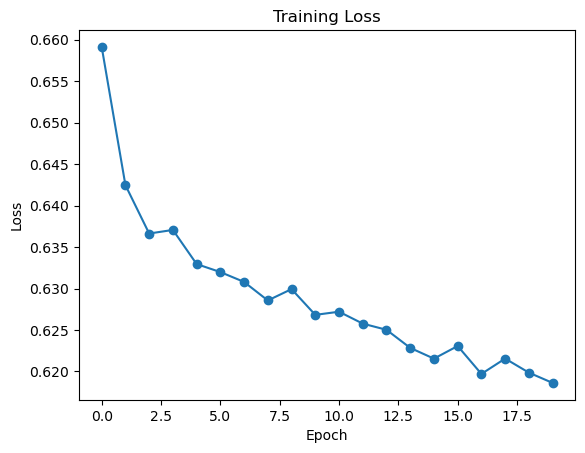

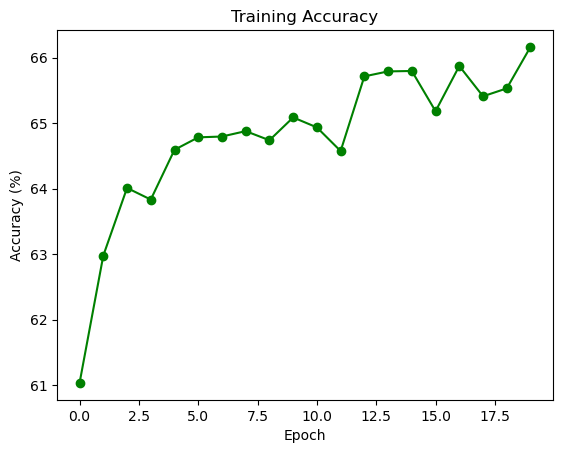

Season 2016 Accuracy: 69.65%


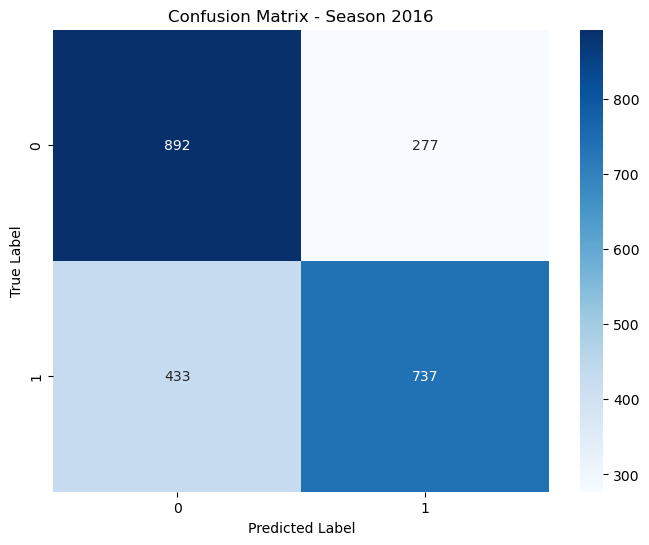

Season 2017 Accuracy: 65.95%


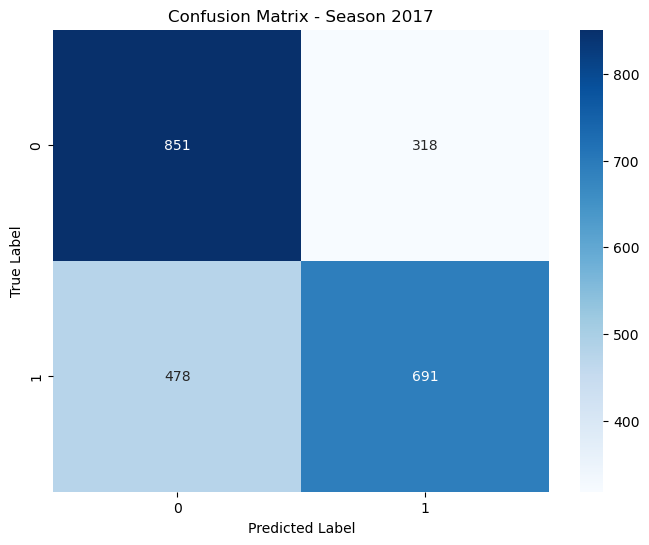

Season 2018 Accuracy: 69.55%


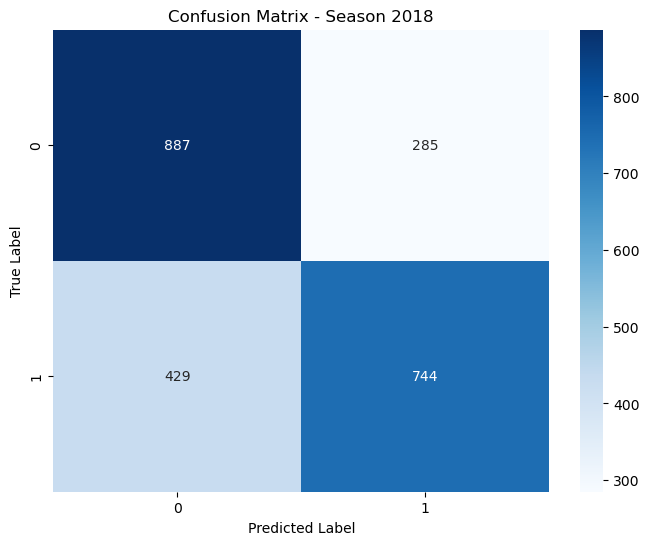

Season 2019 Accuracy: 68.17%


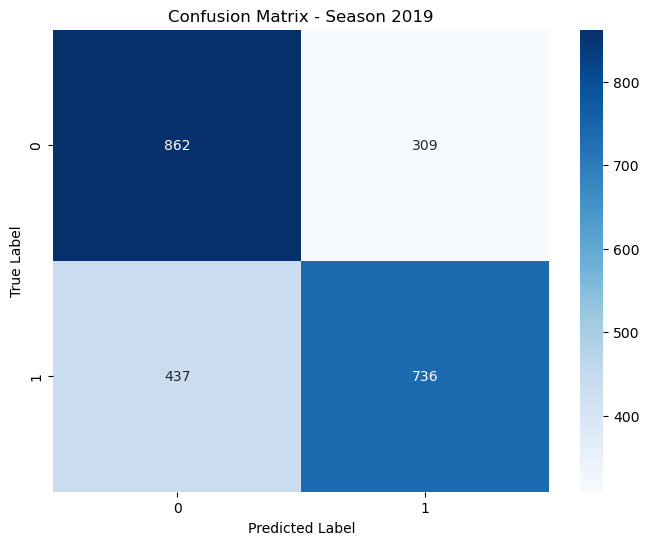

Season 2020 Accuracy: 65.65%


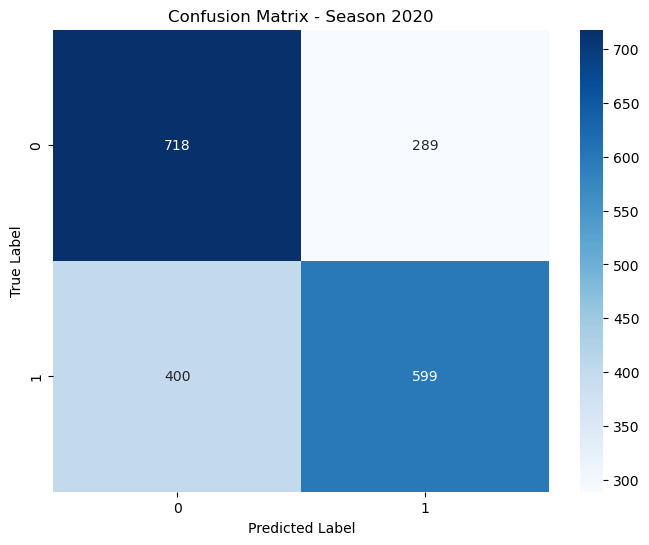

Season 2021 Accuracy: 66.47%


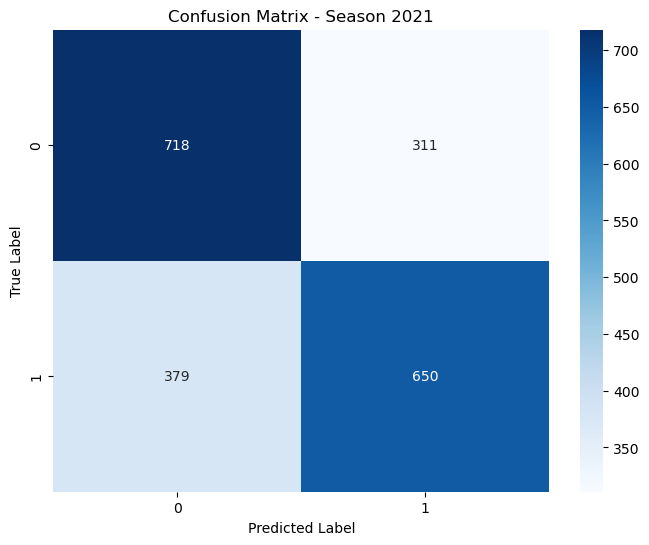

Season 2022 Accuracy: 65.96%


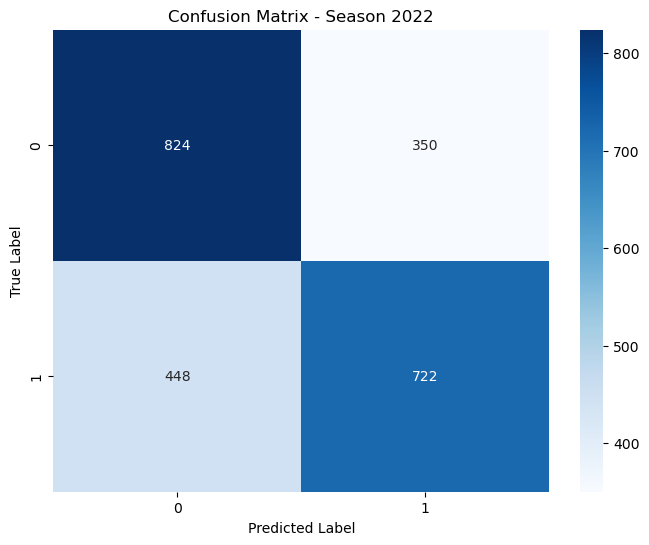

In [389]:
# Specify the relative path to the dataset
relative_path = 'datasets/nba_games.csv'
read_file = os.path.join(os.getcwd(), relative_path)

# Initialize NBADataProcessor and prepare the dataset
data_processor = NBADataProcessor(file_path=read_file)
processed_df = data_processor.prepare_dataset()

# Specify the relative path to save the processed data
output_path = 'datasets/processed_data.csv'
write_file = os.path.join(os.getcwd(), output_path)

# Save the processed DataFrame to a CSV file
processed_df.to_csv(write_file, index=False)
print(f"Processed data saved to: {output_path}")

# # Load the data
train_dataloader, features_columns, features_df = data_processor.load_training_data()

# Initialize the model
input_size = len(features_columns)
print(input_size)
net = SimpleNet(input_size=input_size)

# Train the model
loss_values, accuracy_values = net.train_model(train_dataloader, num_epochs=20, lr=0.001)

#Test model

# Plot loss and accuracy
net.plot_loss(loss_values)
net.plot_accuracy(accuracy_values)

# Perform backtesting
net.backtest(features_df, features_columns)

In [390]:
for col in processed_df.columns:
    print(col)

team_x
mp_10_x
fg_10_x
fga_10_x
fg%_10_x
3p_10_x
3pa_10_x
3p%_10_x
ft_10_x
fta_10_x
ft%_10_x
orb_10_x
drb_10_x
trb_10_x
ast_10_x
stl_10_x
blk_10_x
tov_10_x
pf_10_x
pts_10_x
ts%_10_x
efg%_10_x
3par_10_x
ftr_10_x
orb%_10_x
drb%_10_x
trb%_10_x
ast%_10_x
stl%_10_x
blk%_10_x
tov%_10_x
usg%_10_x
ortg_10_x
drtg_10_x
fg_max_10_x
fga_max_10_x
fg%_max_10_x
3p_max_10_x
3pa_max_10_x
3p%_max_10_x
ft_max_10_x
fta_max_10_x
ft%_max_10_x
orb_max_10_x
drb_max_10_x
trb_max_10_x
ast_max_10_x
stl_max_10_x
blk_max_10_x
tov_max_10_x
pf_max_10_x
pts_max_10_x
+/-_max_10_x
ts%_max_10_x
efg%_max_10_x
3par_max_10_x
ftr_max_10_x
orb%_max_10_x
drb%_max_10_x
trb%_max_10_x
ast%_max_10_x
stl%_max_10_x
blk%_max_10_x
tov%_max_10_x
usg%_max_10_x
ortg_max_10_x
drtg_max_10_x
total_10_x
home_10_x
won_10_x
team_10_x
season_10_x
team_opp_next_x
mp_10_y
fg_10_y
fga_10_y
fg%_10_y
3p_10_y
3pa_10_y
3p%_10_y
ft_10_y
fta_10_y
ft%_10_y
orb_10_y
drb_10_y
trb_10_y
ast_10_y
stl_10_y
blk_10_y
tov_10_y
pf_10_y
pts_10_y
ts%_10_y
efg%_10_y

In [391]:
processed_df

,team_x,mp_10_x,fg_10_x,fga_10_x,fg%_10_x,3p_10_x,3pa_10_x,3p%_10_x,ft_10_x,fta_10_x,...,home_10_y,won_10_y,team_10_y,season_10_y,team_opp_next_y,team_y,home_next,date_next,season,target
0,SAC,0.000,0.463636,0.420588,0.419378,0.286207,0.268182,0.456888,0.358140,0.363492,...,0.4,1,TOR,2016,SAC,TOR,1.0,2015-11-15,2016,1
1,TOR,0.000,0.375000,0.323529,0.390431,0.224138,0.239394,0.382423,0.548837,0.471429,...,0.8,1,SAC,2016,TOR,SAC,0.0,2015-11-15,2016,0
2,CLE,0.050,0.438636,0.355882,0.447608,0.317241,0.351515,0.401306,0.372093,0.373016,...,0.3,0,DET,2016,CLE,DET,0.0,2015-11-17,2016,0
3,GSW,0.025,0.534091,0.416176,0.510526,0.431034,0.398485,0.499644,0.369767,0.338095,...,0.3,0,TOR,2016,GSW,TOR,1.0,2015-11-17,2016,1
4,DEN,0.000,0.395455,0.367647,0.391627,0.265517,0.303030,0.389786,0.390698,0.365079,...,0.4,0,NOP,2016,DEN,NOP,0.0,2015-11-17,2016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,BOS,0.000,0.386364,0.283824,0.441627,0.455172,0.471212,0.439667,0.458140,0.393651,...,0.6,0,GSW,2022,BOS,GSW,1.0,2022-06-10,2022,0
15770,GSW,0.000,0.502273,0.388235,0.500478,0.493103,0.501515,0.458789,0.309302,0.276190,...,0.5,0,BOS,2022,GSW,BOS,1.0,2022-06-13,2022,1
15771,BOS,0.000,0.381818,0.292647,0.428230,0.468966,0.477273,0.448100,0.434884,0.373016,...,0.6,1,GSW,2022,BOS,GSW,0.0,2022-06-13,2022,0
15772,GSW,0.000,0.502273,0.364706,0.517703,0.455172,0.481818,0.440736,0.320930,0.282540,...,0.5,0,BOS,2022,GSW,BOS,0.0,2022-06-16,2022,1


In [392]:
processed_data_path = 'datasets/processed_data.csv'

#read_file = os.path.join(os.getcwd(), processed_data_path)
# Read the processed data CSV file to get column headers
processed_data_df = pd.read_csv(processed_data_path)
processed_data_df

,team_x,mp_10_x,fg_10_x,fga_10_x,fg%_10_x,3p_10_x,3pa_10_x,3p%_10_x,ft_10_x,fta_10_x,...,home_10_y,won_10_y,team_10_y,season_10_y,team_opp_next_y,team_y,home_next,date_next,season,target
0,SAC,0.000,0.463636,0.420588,0.419378,0.286207,0.268182,0.456888,0.358140,0.363492,...,0.4,1,TOR,2016,SAC,TOR,1.0,2015-11-15,2016,1
1,TOR,0.000,0.375000,0.323529,0.390431,0.224138,0.239394,0.382423,0.548837,0.471429,...,0.8,1,SAC,2016,TOR,SAC,0.0,2015-11-15,2016,0
2,CLE,0.050,0.438636,0.355882,0.447608,0.317241,0.351515,0.401306,0.372093,0.373016,...,0.3,0,DET,2016,CLE,DET,0.0,2015-11-17,2016,0
3,GSW,0.025,0.534091,0.416176,0.510526,0.431034,0.398485,0.499644,0.369767,0.338095,...,0.3,0,TOR,2016,GSW,TOR,1.0,2015-11-17,2016,1
4,DEN,0.000,0.395455,0.367647,0.391627,0.265517,0.303030,0.389786,0.390698,0.365079,...,0.4,0,NOP,2016,DEN,NOP,0.0,2015-11-17,2016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,BOS,0.000,0.386364,0.283824,0.441627,0.455172,0.471212,0.439667,0.458140,0.393651,...,0.6,0,GSW,2022,BOS,GSW,1.0,2022-06-10,2022,0
15770,GSW,0.000,0.502273,0.388235,0.500478,0.493103,0.501515,0.458789,0.309302,0.276190,...,0.5,0,BOS,2022,GSW,BOS,1.0,2022-06-13,2022,1
15771,BOS,0.000,0.381818,0.292647,0.428230,0.468966,0.477273,0.448100,0.434884,0.373016,...,0.6,1,GSW,2022,BOS,GSW,0.0,2022-06-13,2022,0
15772,GSW,0.000,0.502273,0.364706,0.517703,0.455172,0.481818,0.440736,0.320930,0.282540,...,0.5,0,BOS,2022,GSW,BOS,0.0,2022-06-16,2022,1


In [393]:
# # Specify the relative path to the dataset
# relative_path = 'datasets/processed_data_csv.csv'
# write_file = os.path.join(os.getcwd(), relative_path)

# # Write processed_df to a CSV file
# processed_df.to_csv(write_file, index=False)

# # Print a message indicating the successful write
# print(f"DataFrame successfully written to {write_file}")

In [394]:
# def plot_loss(loss_values, title="Training Loss"):
#     plt.plot(loss_values, marker='o')
#     plt.title(title)
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.show()

# def plot_accuracy(accuracy_values, title="Training Accuracy"):
#     plt.plot(accuracy_values, marker='o', color='green')
#     plt.title(title)
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy (%)")
#     plt.show()

# # Function to perform backtesting
# def backtest(model, data, predictors, start=0, step=1):

#     seasons = sorted(data["season"].unique())
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     for i in range(start, len(seasons), step):
#         season = seasons[i]
#         test_df = data[data["season"] == season]

#         target_column = "target"

#         # Extract features
#         test_features = test_df[predictors].values
#         test_target = test_df[target_column].values

#         test_dataset = NBADataset(test_features, test_target)
#         test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#         model.eval()  # Set the model to evaluation mode

#         all_labels = []
#         all_predictions = []

#         with torch.no_grad():
#             correct = 0
#             total = 0

#             for inputs, labels in test_dataloader:
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 outputs = model(inputs)
#                 predicted = torch.round(outputs)

#                 total += labels.size(0)
#                 correct += (predicted == labels.unsqueeze(1)).sum().item()

#                 # Collect labels and predictions for confusion matrix
#                 all_labels.extend(labels.cpu().numpy())
#                 all_predictions.extend(predicted.cpu().numpy().flatten())

#         accuracy = correct / total
#         print(f"Season {season} Accuracy: {accuracy * 100:.2f}%")

#         # Create confusion matrix
#         conf_matrix = confusion_matrix(all_labels, all_predictions)

#         # Plot confusion matrix using seaborn
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
#         plt.title(f"Confusion Matrix - Season {season}")
#         plt.xlabel("Predicted Label")
#         plt.ylabel("True Label")
#         plt.show()

In [395]:
# season_df = processed_df[["season", "target"]].copy()

# # Extract features and target using the _extract_features method
# features_df = data_processor._extract_features(processed_df)

# # Concatenate season and date columns back to features dataframe
# features_df = pd.concat([season_df, features_df], axis=1)

# # Define features and target
# target_column = "target"

# # Define features and target
# features_columns = [col for col in features_df.columns if col not in ["season", "target"]]

# #Separate validation set

# # Identify the cutoff season (e.g., 2022)
# cutoff_season = 2022

# # # Divide the data into training and testing sets
# # train_df = features_df[features_df["season"] < cutoff_season]
# test_df = features_df[features_df["season"] == cutoff_season]

# # Extract features and target for testing set
# test_features = test_df[features_columns].values
# test_target = test_df[target_column].values

# # Create DataLoader for testing
# test_dataset = NBADataset(test_features, test_target)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Extract features and target for training and testing sets
# train_features = features_df[features_columns].values
# train_target = features_df[target_column].values

# # # Create DataLoader for training
# train_dataset = NBADataset(train_features, train_target)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [396]:
# # Initialize and train the model
# input_size = len(features_columns)
# net = SimpleNet(input_size=input_size)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net.to(device)

# criterion = torch.nn.BCELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

# # Training loop
# num_epochs = 30

# loss_values = []  # To store the loss for each epoch
# accuracy_values = []  # To store the accuracy for each epoch

In [397]:
# for epoch in range(num_epochs):
#     net.train()
#     total_correct = 0
#     total_examples = 0
#     epoch_loss = 0.0

#     for inputs, labels in train_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         outputs = net(inputs)
#         loss = criterion(outputs, labels.unsqueeze(1))

#         # Calculate accuracy
#         predictions = (outputs > 0.5).float()
#         correct = (predictions == labels.unsqueeze(1)).float().sum()
#         total_correct += correct
#         total_examples += labels.size(0)

#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     # Learning rate scheduling
#     if epoch % 5 == 0:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] *= 0.9  # Reduce learning rate by 10% every 5 epochs

#     # Calculate accuracy and loss for the epoch
#     accuracy = (total_correct / total_examples) * 100.0
#     average_loss = epoch_loss / len(train_dataloader)

#     # Store loss and accuracy values
#     loss_values.append(average_loss)
#     accuracy_values.append(accuracy)

#     # Print the loss and accuracy for each epoch
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [398]:
# # Evaluation on testing data
# net.eval()
# all_labels = []
# all_predictions = []

# with torch.no_grad():
#     correct = 0
#     total = 0

#     for inputs, labels in test_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         outputs = net(inputs)
#         predicted = torch.round(outputs)

#         total += labels.size(0)
#         correct += (predicted == labels.unsqueeze(1)).sum().item()

#         # Collect labels and predictions for confusion matrix
#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())

#     accuracy = correct / total
#     print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [399]:
# # Create confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_predictions)

# # Plot confusion matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()